# TCGA-OV Genomic Data Analysis

## 1. [Mutational Landscape in COSMIC Genes](#Mutational-Landscape-in-COSMIC-Genes)
## 2. [Tumor Mutation Burden]()
* ### 2.1 [Effect of Impaired DNA-repair Genes on TMB](#Effect-of-Impaired-DNA-repair-Genes-on-TMB)
## 3. [Selection Quantification](#Selection-Quantification)
* ### 3.1 [Global dNdS Ratio](#Global-dNdS-Ratio)
* ### 3.2 [Gene-set dNdS Ratio](#Gene-set-dNdS-Ratio)
## 4. [Summary](#Summary)

## Dependencies

In [1]:
import pkg_resources, json
import pandas as pd
import numpy as np
import bambi
import arviz

%load_ext rpy2.ipython

In [2]:
%%R

packages <- c('dplyr','knitr','kableExtra','ComplexHeatmap','gridExtra',
                   'ggplot2','patchwork','ggrepel','forcats','ggpubr','dndscv')

suppressPackageStartupMessages({
    for (pkg in packages) {
      library(pkg, character.only = TRUE)
    }
})

source("sample_data/oncomap.R")

theme <- theme_classic() + theme(plot.title = element_text(hjust = 0.5, size = 20), axis.text = element_text(size=22.5), axis.title = element_text(size=25),
                                 legend.text= element_text(size=20), legend.title=element_text(size=20),
                                 strip.text = element_text(size = 20))

stage_colors <- c('#00C9AC', '#C9001D')

In [3]:
tcgaOV_clin = pd.read_csv('sample_data/tcgaOV_clinical.tsv', sep='\t')
ov_genomics_genes = pd.read_csv('sample_data/ov_genomics_genes.tsv', sep='\t')

# Mutational Landscape in COSMIC Genes
Task: Assess the frequencies of potentially pathogenic mutations (REVEL score >= 0.38) observed in known cancer-associated genes for TCGA-OV cohort.

In [4]:
with open("sample_data/oncomap_data.json", "r") as f:
    oncomap_allcosmic_data = json.load(f)

tcgaOV_clin_om = tcgaOV_clin.drop(['Age'], axis=1) # Rpush doesn't like a column with mixed data types

e_samples = pd.DataFrame(oncomap_allcosmic_data['e_samples'])
l_samples = pd.DataFrame(oncomap_allcosmic_data['l_samples'])
om_revel_e_allcosmic = pd.DataFrame(oncomap_allcosmic_data['om_revel_e_allcosmic'])
om_revel_l_allcosmic = pd.DataFrame(oncomap_allcosmic_data['om_revel_l_allcosmic'])

In [5]:
%Rpush om_revel_e_allcosmic om_revel_l_allcosmic tcgaOV_clin_om e_samples l_samples

R[write to console]: All mutation types: SNV, DEL, INS.

R[write to console]: `alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.

R[write to console]: All mutation types: SNV, DEL, INS.

R[write to console]: `alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.



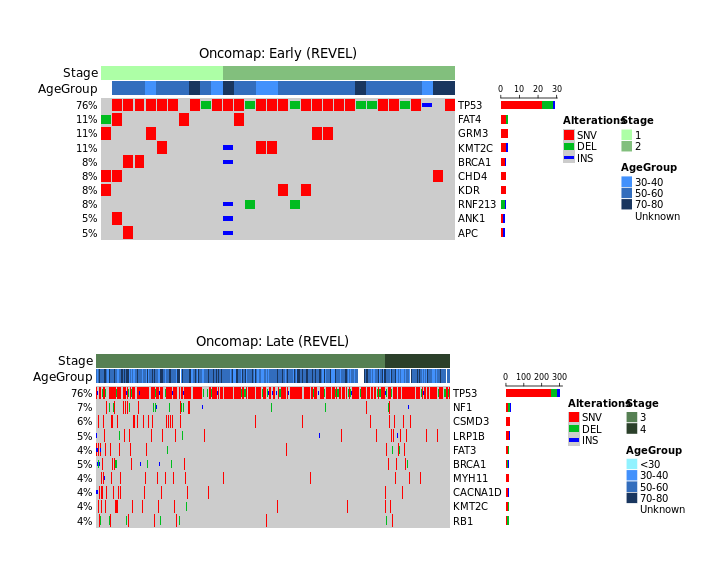

In [6]:
%%R -w 10 -h 8 -u in

t_rv_early <- grid.grabExpr(plot_oncomap(e_samples, om_revel_e_allcosmic, tcgaOV_clin_om, 'Oncomap: Early (REVEL)'))
t_rv_late <- grid.grabExpr(plot_oncomap(l_samples, om_revel_l_allcosmic, tcgaOV_clin_om, 'Oncomap: Late (REVEL)'))
grid.arrange(t_rv_early, t_rv_late)

# Tumor Mutation Burden (TMB)

Explore TMB observed in early- and late-stage patients in TCGV-OV cohort

In [7]:
with open("sample_data/tmb_data.json", "r") as f:
    tmb = json.load(f)
    
tmb_data = pd.DataFrame(tmb['tmb_data'])
grade_bp_data = tmb_data[['Stage','Grade']].value_counts().rename('Count').reset_index()

In [8]:
%Rpush tmb_data grade_bp_data

`geom_smooth()` using formula = 'y ~ x'


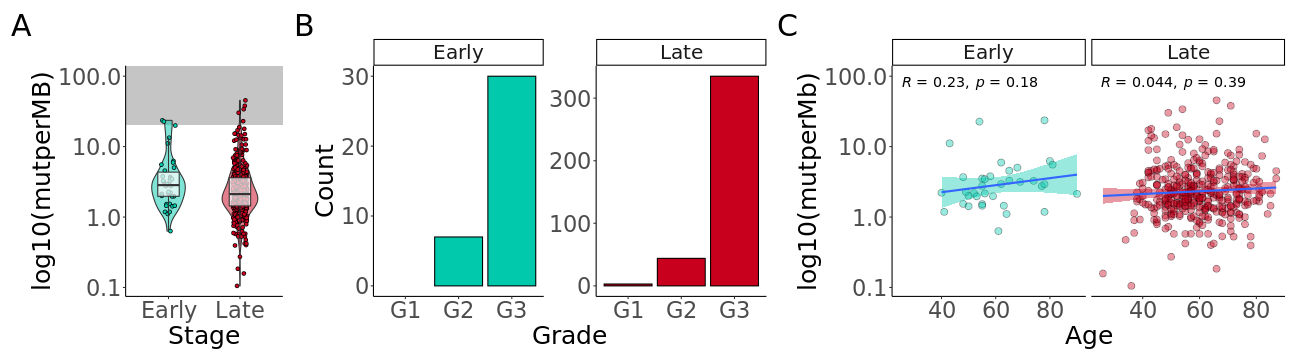

In [9]:
%%R -u in -w 18 -h 5

# Gray-shaded area (geom_rect) indicate 'High' mutation tier category as per Chalmers 2018
stage_vp <- ggplot(tmb_data, aes(x=Stage, y=mutperMb, fill=Stage)) + 
                geom_rect(aes(xmin=-Inf,xmax=Inf,ymin=20,ymax=Inf),alpha=1,fill="#C5C5C5") +
                geom_violin(width=.5, alpha=0.5)+ geom_jitter(width=.1, pch=21) + geom_boxplot(width=.3, fill='white', alpha=0.7, outlier.alpha=0) +
                ylab('log10(mutperMB)') + scale_fill_manual(values=stage_colors) +
                scale_y_continuous(trans='log10', limits=c(NA, 100)) + theme + theme(legend.position='none')

tmb_age_corr <- ggplot(data=tmb_data %>% filter(Age != 'Unknown'), aes(x=as.numeric(Age), y=mutperMb, fill=Stage)) + 
                    geom_point(pch=21, alpha=0.4, size=3) + geom_smooth(method = "lm", se = TRUE) +
                    stat_cor(method = "spearman", label.x = 25, label.y = 1.9, size=5) +
                    scale_y_continuous(trans='log10', limits=c(NA, 100)) + scale_fill_manual(values=c(stage_colors)) +
                    xlab('Age') + ylab('log10(mutperMb)') +
                    facet_grid(cols=vars(Stage), scales='free') + theme + theme(legend.position='none')

grade_bp <- ggplot(grade_bp_data, aes(x=Grade, y=Count, fill=Stage)) + geom_bar(stat='identity', position=position_dodge(), color='black') + 
                   scale_fill_manual(values=c(stage_colors)) + facet_wrap(~Stage, scales='free') +
                   scale_x_discrete(limits=c('G1','G2','G3')) + theme + theme(legend.position='none')

stage_vp + grade_bp + tmb_age_corr + plot_layout(widths = c(.4, 1,1)) + plot_annotation(tag_levels = 'A') & theme(plot.tag=element_text(size = 30))

In [10]:
high_burden = tmb_data[tmb_data.mutperMb > 20].sort_values(by=['Stage', 'mutperMb'], ascending=(True, False)) # Samples belonging to 'High' mutation tier category
high_burden

,Case,Age,AgeGroup,Grade,Stage,Counts,Target_Region,mutperMb,Normal,mutTier,Impaired_DNA_Repair_TMB
152,TCGA-20-0991,78,70-80,G3,Early,779.0,33.0,23.606061,BN,High,2.0
422,TCGA-61-2113,54,50-60,G3,Early,748.0,33.0,22.666667,SN,High,2.0
125,TCGA-13-1492,66,50-60,G3,Late,545.0,12.0,45.416667,BN,High,2.0
64,TCGA-13-0757,71,70-80,G3,Late,456.0,12.0,38.000000,BN,High,2.0
414,TCGA-61-2095,54,50-60,G2,Late,1121.0,33.0,33.969697,SN,High,0.0
115,TCGA-13-1477,49,30-40,G2,Late,363.0,12.0,30.250000,BN,High,3.0
211,TCGA-24-1431,67,50-60,G3,Late,736.0,32.0,23.000000,BN,High,1.0


Overall, early- and late-stage patients show a minor difference in observed TMB with the IQRs showing overlap. Moreover, both stage groups had a similar distribution of tumor grade and showing no correlation between age and TMB. Since it is hard to tell whether there is any notable difference in TMB between early- and late-stage groups, we turn to Bayesian analysis to estimate the effect of stage on observed TMB.

In [11]:
tmb_data_bm = tmb_data.assign(log10_mutperMb=np.log10(tmb_data.mutperMb))
tmb_gaussian = bambi.Model("log10_mutperMb ~ Stage", tmb_data_bm, family="gaussian")
tmb_gaussian_results = tmb_gaussian.fit(draws=5000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log10_mutperMb_sigma, Intercept, Stage]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


<Axes: xlabel='log10_mutperMb / log10_mutperMb'>

/home/dban/miniconda3/envs/missionbio/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dban/miniconda3/envs/missionbio/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


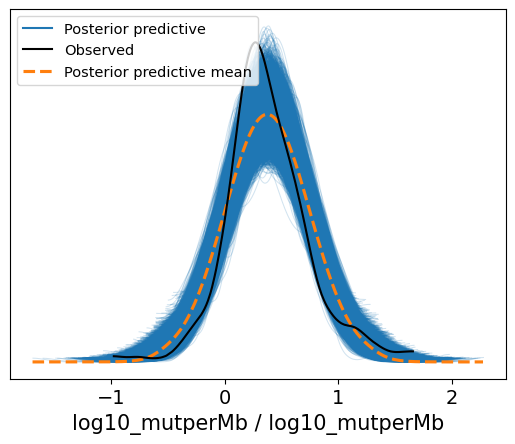

In [12]:
tmb_gaussian.predict(tmb_gaussian_results, kind="pps")
arviz.plot_ppc(tmb_gaussian_results)

In [13]:
arviz.summary(tmb_gaussian_results).head(2)[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
Intercept,0.497,0.058,0.39,0.606
Stage[Late],-0.133,0.061,-0.25,-0.024


The mean value of -0.133 when late-stage is considered, indicate the following: the average of the log10-transformed response variable is estimated to be 0.133 units lower than when early-stage group is considered. This translates into  0.72 (10^-0.133) on the original scale of TMB. Therefore, we can say that TMB levels in the late-stage group is 28% smaller. However, we should note that the 94% high density interval (HDI) is rather wide.

## Effect of Impaired DNA-repair Genes on TMB

List of DNA-repair genes used in this analysis is from [Chae et al 2016](https://pubmed.ncbi.nlm.nih.gov/27004405/)

* Nucleotide Excision Repair (NER) - Main pathway used by mammals to remove bulky DNA lesions such as those formed by UV light, environmental mutagens, and some cancer chemotherapeutic adducts from DNA.
* Base Excision Repair (BER) - Corrects DNA damage from oxidation, deamination and alkylation. Such base lesions cause little distortion to the DNA helix structure.
* Mismatch Repair (MMR) - A system for recognizing and repairing erroneous insertion, deletion, and mis-incorporation of bases that can arise during DNA replication and recombination, as well as repairing some forms of DNA damage.

In [14]:
chae2016_freq = pd.read_csv('sample_data/tcgaOV_chae2016_freq.tsv', sep='\t')

In [15]:
%%R -i chae2016_freq -w 7 -h 4 -u in

chae2016_freq <- chae2016_freq %>% filter(Type %in% c('BER','NER','MMR'))

rep_cohort_freq <- ggplot(chae2016_freq, aes(x=Type, y=Freq)) + 
                    geom_jitter(shape=21, aes(stroke=1), width=0.2, size=4, alpha=0.3, fill='black') +
                    geom_text_repel(aes(label=ifelse(Freq>0.01,as.character(Gene),'')), point.padding=unit(0.5,'lines'), size=5) +
                    scale_y_continuous(labels = scales::percent) +
                    theme + theme(axis.text.x=element_text(angle=0),legend.position='bottom') +
                    xlab('DNA-repair mechanism') + ylab('Frequency') + guides(fill = guide_legend(nrow = 1))

In [16]:
tmb_data = tmb_data.assign(Impaired_DNA_Repair_TMB_Status=tmb_data.Impaired_DNA_Repair_TMB.apply(lambda x: 'Yes' if x > 0 else 'No'))
tmb_data = tmb_data.assign(mutperMb_adjusted = tmb_data.apply(lambda x: (x.Counts - x.Impaired_DNA_Repair_TMB) / x.Target_Region, axis=1))

dnarep_tmb_table = tmb_data.groupby(['Impaired_DNA_Repair_TMB_Status']).agg({'Case':'count','mutperMb_adjusted':'median' }).reset_index()\
                    .rename(columns={'Impaired_DNA_Repair_TMB_Status':'Impaired_Status', 'mutperMb_adjusted':'median_mutperMb'}) # rename the column for visualizing the table

In [17]:
%Rpush tmb_data

In [18]:
%%R

tcga_dna_bp <- ggplot(tmb_data, aes(x=Impaired_DNA_Repair_TMB_Status, y=mutperMb_adjusted, fill=Impaired_DNA_Repair_TMB_Status)) +
                    geom_rect(aes(xmin=-Inf,xmax=Inf,ymin=16,ymax=Inf),alpha=1,fill="#C5C5C5") +
                    stat_boxplot(position=position_dodge(1), geom ='errorbar', width=0.1) + geom_jitter(shape=21, size=2, aes(stroke=.66), width=.075) +
                    geom_violin(position=position_dodge(1), alpha=0.3) + geom_boxplot(width=0.2, alpha=0.7, fill='white', outlier.alpha = 0) +
                    theme + xlab('Impaired Status') + ylab('log10(mutperMB)') +
                    scale_y_continuous(trans='log10', limit=c(NA,20)) + theme + theme(legend.position='none') + 
                    scale_fill_manual(values=c('#854DB2', '#7AB24D'))

no_axes <- theme(legend.position='none', axis.title.y=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank(), # theme specific for dnarep_tmb_corr
                 axis.text.x=element_blank(), axis.ticks.x=element_blank())
dnarep_tmb_corr <- ggplot(tmb_data, aes(x=Impaired_DNA_Repair_TMB, y=mutperMb_adjusted, fill=Stage)) +
                        geom_smooth(method = "lm", se = TRUE) + 
                        stat_cor(method = "spearman", label.x = 0, label.y = 50, size=5)+ facet_wrap(~Stage, scales='free_x') +
                        geom_point(pch=21, alpha=0.4, size=3) +
                        scale_fill_manual(values=c(stage_colors)) +
                        theme + theme(legend.position='none') + xlab('# of Impaired\nDNA-repair genes (TMB)') + ylab('log10(mutperMb)')

In [19]:
%%R -u in -w 6 -h 5

# since the rankings based on the # of impaired genes aren't optimal (small range), the goal here is to
# perform permutation test to see how Spearman rank coefficient (rho) is impacted when 
spearman_permutation_test <- function(x, y, n_perm = 1000) {
  
    # calculate the original rho and p-value
    original_test <- cor.test(x, y, method = "spearman")
    original_rho <- original_test$estimate
    original_p <- original_test$p.value
  
    # perform the permutation test
    perm_rho <- replicate(n_perm, {
        y_perm <- sample(y)
        cor.test(x, y_perm, method = "spearman")$estimate
    })
  
    # calculate the p-value of the permutation test
    perm_p <- mean(abs(perm_rho) >= abs(original_rho))
  
    list(original_rho = original_rho, original_p = original_p, perm_rho = perm_rho, perm_p = perm_p
  )
}

tmb_data_e <- tmb_data %>% filter(Stage == 'Early')
tmb_data_l <- tmb_data %>% filter(Stage == 'Late')

tmb_data_e_x <-  tmb_data_e$mutperMb_adjusted
tmb_data_e_y <-  tmb_data_e$Impaired_DNA_Repair_TMB

tmb_data_l_x <-  tmb_data_l$mutperMb_adjusted
tmb_data_l_y <-  tmb_data_l$Impaired_DNA_Repair_TMB

perm_test_e <- spearman_permutation_test(tmb_data_e_x, tmb_data_e_y)
perm_test_l <- spearman_permutation_test(tmb_data_l_x, tmb_data_l_y)
perm_test_hist_data <- rbind(as.data.frame(list(Perm_Rho=perm_test_e$perm_rho, Stage='Early')),
                             as.data.frame(list(Perm_Rho=perm_test_l$perm_rho, Stage='Late')))

print(perm_test_e$perm_p)
print(perm_test_l$perm_p)

dnarep_perm_test <- ggplot(perm_test_hist_data, aes(x=Perm_Rho, fill=Stage)) + geom_histogram(alpha=0.5, bins=25, color='black') +
                        annotate("text", x = 0.325, y = 500, label = paste0('[Early] p-value: ',perm_test_e$perm_p), size=5) +
                        annotate("text", x = 0.275, y = 475, label = paste0('[Late]  p-value: ',perm_test_l$perm_p), size=5) +
                        xlab('rho (Permuted)') + ylab('Counts') +
                        theme + scale_fill_manual(values=stage_colors)

[1] 0.017
[1] 0


`geom_smooth()` using formula = 'y ~ x'


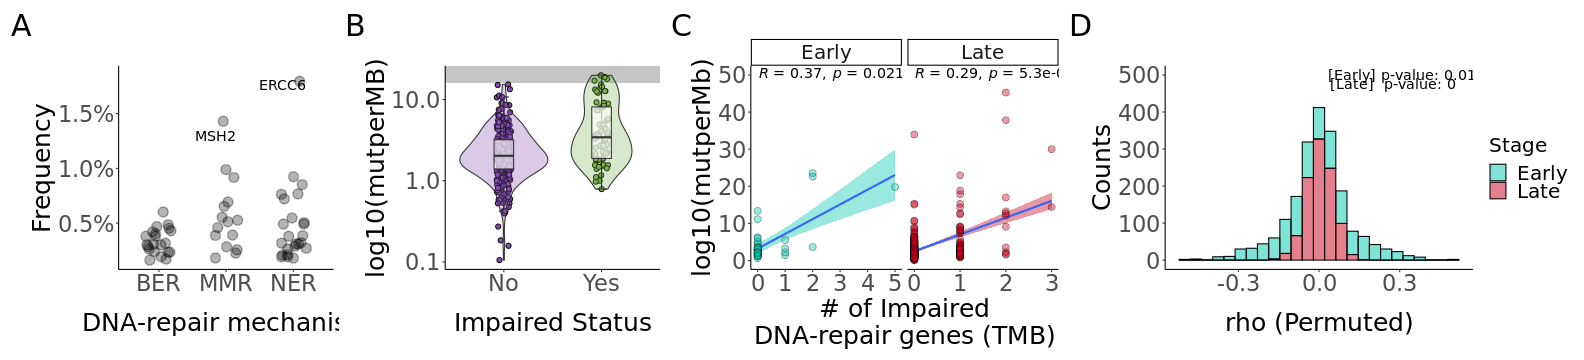

In [20]:
%%R -u in -w 22 -h 5
((rep_cohort_freq + tcga_dna_bp) | (dnarep_tmb_corr + dnarep_perm_test)) + 
    plot_layout(widths=c(1.5,2)) +
    plot_annotation(tag_levels = 'A') & theme(plot.tag=element_text(size = 30))

In [21]:
tmb_data_bm = tmb_data.assign(log10_mutperMb_adjusted=np.log10(tmb_data.mutperMb_adjusted))
tmb_dnarep_gaussian = bambi.Model("log10_mutperMb_adjusted ~ Stage + Impaired_DNA_Repair_TMB_Status", tmb_data_bm, family="gaussian")
tmb_dnarep_gaussian_results = tmb_dnarep_gaussian.fit(draws=5000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log10_mutperMb_adjusted_sigma, Intercept, Stage, Impaired_DNA_Repair_TMB_Status]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 46 seconds.


<Axes: xlabel='log10_mutperMb_adjusted / log10_mutperMb_adjusted'>

/home/dban/miniconda3/envs/missionbio/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dban/miniconda3/envs/missionbio/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


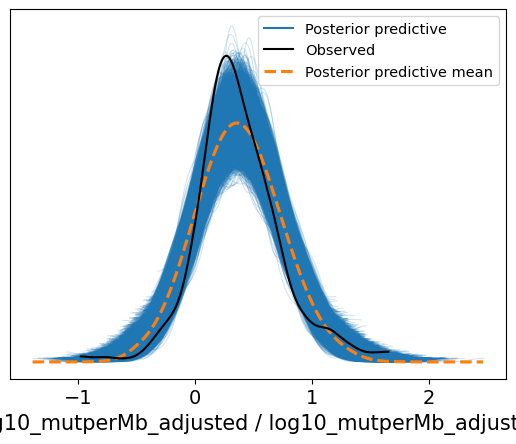

In [22]:
tmb_dnarep_gaussian.predict(tmb_dnarep_gaussian_results, kind="pps")
arviz.plot_ppc(tmb_dnarep_gaussian_results)

In [23]:
arviz.summary(tmb_dnarep_gaussian_results).head(3)[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
Intercept,0.425,0.055,0.322,0.530
Stage[Late],-0.119,0.057,-0.224,-0.008
Impaired_DNA_Repair_TMB_Status[Yes],0.336,0.043,0.259,0.420


Similar to the results from the previous Bayesian analysis, the mean value of -0.119 for late-stage indicate that the group's TMB level is  0.76 (10^-0.119) or 24% smaller than TMB observed in early-stage. Interestingly, the impaired DNA-repair status shows the mean value of 2.15 (10^0.336) with a more reliable 94% HDI, indicating individuals belonging to this group are expected to have 115% higher TMB.

# Selection Quantification

## Global dNdS Ratio

In [24]:
tcgaOV_all_a_dndscv = pd.read_csv('sample_data/tcgaOV_dndscv_input.tsv', sep='\t')
tcgaOV_all_a_dndscv[(tcgaOV_all_a_dndscv.ref.apply(lambda x: len(x) == 1)) & # make sure ref/alt are of length 1
                    (tcgaOV_all_a_dndscv.mut.apply(lambda x: len(x) == 1))]

# prep data for stage-level as well as cohort-level analysis using dndscv
tcgaOV_all_a_dndscv_e = tcgaOV_all_a_dndscv[tcgaOV_all_a_dndscv.Stage == 'Early'].drop(['Stage'], axis=1).reset_index(drop=True)
tcgaOV_all_a_dndscv_l = tcgaOV_all_a_dndscv[tcgaOV_all_a_dndscv.Stage == 'Late'].drop(['Stage'], axis=1).reset_index(drop=True)
tcgaOV_all_a_dndscv = tcgaOV_all_a_dndscv.drop(['Stage'], axis=1).reset_index(drop=True)
tcgaOV_all_a_dndscv_l

,sampleID,chr,pos,ref,mut
0,TCGA-04-1331,chr1,31736620,C,G
1,TCGA-04-1331,chr1,39897856,T,G
2,TCGA-04-1331,chr1,40626667,G,T
3,TCGA-04-1331,chr1,44978449,C,A
4,TCGA-04-1331,chr1,46286325,C,T
...,...,...,...,...,...
53437,TCGA-WR-A838,chr19,16869612,C,T
53438,TCGA-WR-A838,chr19,39435891,G,C
53439,TCGA-WR-A838,chr19,54146614,A,G
53440,TCGA-WR-A838,chr20,32073768,C,T


In [25]:
%%time
%%R -i tcgaOV_all_a_dndscv_e -i tcgaOV_all_a_dndscv_l -i tcgaOV_all_a_dndscv

dndscv_e_out <- dndscv(tcgaOV_all_a_dndscv_e, refdb='sample_data/GRCh38.autoXY.dndscv.refcds.rda', cv=NULL, outmats=T)
dndscv_l_out <- dndscv(tcgaOV_all_a_dndscv_l, refdb='sample_data/GRCh38.autoXY.dndscv.refcds.rda', cv=NULL, outmats=T)
dndscv_out <- dndscv(tcgaOV_all_a_dndscv, refdb='sample_data/GRCh38.autoXY.dndscv.refcds.rda', cv=NULL, outmats=T)

R[write to console]: [1] Loading the environment...

R[write to console]: [2] Annotating the mutations...

R[write to console]:     Note: 7 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

R[write to console]: [3] Estimating global rates...

R[write to console]: [4] Running dNdSloc...

R[write to console]: [5] Running dNdScv...

R[write to console]:     Regression model for substitutions: no covariates were used (theta = 4.2).

R[write to console]:     Regression model for indels (theta = 0.395)

R[write to console]: [1] Loading the environment...

R[write to console]: [2] Annotating the mutations...

R[write to console]:     Note: 50 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

R[write to console]:     21% ...

R[write to console]:     43% ...

R[write to console]:     64% ...

R[write to console]:     86% ...

R[

CPU times: user 3min 28s, sys: 5.22 s, total: 3min 33s
Wall time: 3min 29s


In [26]:
%%R

global_ov_dnds <- rbind(dndscv_e_out$globaldnds['wall',], dndscv_l_out$globaldnds['wall',])
rownames(global_ov_dnds) <- c('Early_Ratio', 'Late_Ratio')
global_ov_dnds

            name      mle     cilow   cihigh
Early_Ratio wall 1.031821 0.9705085 1.097008
Late_Ratio  wall 1.068715 1.0441570 1.093850


The global dnds according to dndscv (`[Early] dN/dS ratio estimate: 1.03, CI: 0.97-1.097, [Late] dN/dS ratio estimate: 1.06, CI: 1.04-1.093`) suggest that the mutations are occurring at random, with no discernable selection pattern in both early- and late-stage groups. This is consistent with the findings with analyses performed on TCGA samples reported by the package developers. Since we were able to replicate the results, we move onto looking at specific gene groups in early- and late-stage ovarian cancer as the signal for selection may be more apparent in cancer-associated genes.

## Gene-set dNdS Ratio

In [27]:
# COSMIC genes
all_cos = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'all_cos'].Gene.tolist()
tsg_no_ocg = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'tsg_no_ocg'].Gene.tolist()
ocg_no_tsg = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'ocg_no_tsg'].Gene.tolist()
tsg_no_ocg.append('TP53') # We add TP53 as a TSG since it's well-known for its role as a tumor-suppressor

# DNA repair genes
rep_all = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'rep_all'].Gene.tolist()
rep_direct = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'rep_direct'].Gene.tolist()
rep_indirect = ov_genomics_genes[ov_genomics_genes.Gene_Type == 'rep_indirect'] .Gene.tolist()

In [28]:
%Rpush all_cos tsg_no_ocg ocg_no_tsg

In [29]:
%%time
%%R 

gene_dnds <- function(dndscv_e_out, dndscv_l_out, dndscv_out, genes) { # helper function to create a list of dndscv results for gene sets
    gene_dnds_e <- genesetdnds(dndscv_e_out, genes)
    gene_dnds_l <- genesetdnds(dndscv_l_out, genes)
    gene_dnds <- genesetdnds(dndscv_out, genes)
    return(list(early=gene_dnds_e, late=gene_dnds_l, all=gene_dnds))
}

# making sure that we only utilize genes that were found to have mutations with 'intersect'
dndscv_genes <- dndscv_e_out$sel_cv$gene_name
all_cos_dndscv <- intersect(all_cos, dndscv_genes)
tsg_dndscv <- intersect(tsg_no_ocg, dndscv_genes)
ocg_dndscv <- intersect(ocg_no_tsg, dndscv_genes)
ncos_dndscv <- setdiff(dndscv_genes, all_cos)

all_cos_gene_dnds <- gene_dnds(dndscv_e_out, dndscv_l_out, dndscv_out, all_cos_dndscv)
tsg_gene_dnds <- gene_dnds(dndscv_e_out, dndscv_l_out, dndscv_out, tsg_dndscv)
ocg_gene_dnds <- gene_dnds(dndscv_e_out, dndscv_l_out, dndscv_out, ocg_dndscv)
ncos_gene_dnds <- gene_dnds(dndscv_e_out, dndscv_l_out, dndscv_out, ncos_dndscv)

CPU times: user 49.4 s, sys: 2.53 s, total: 51.9 s
Wall time: 25.9 s


In [30]:
%%R

all_cos_ov_dnds <- rbind(all_cos_gene_dnds$early$globaldnds_geneset['wall',],all_cos_gene_dnds$late$globaldnds_geneset['wall',])
rownames(all_cos_ov_dnds) <- c('Early_Ratios', 'Late_Ratios')
all_cos_ov_dnds

                  mle     cilow   cihigh
Early_Ratios 1.239804 0.9719529 1.581470
Late_Ratios  1.197244 1.0989089 1.304379


When all cosmic genes are considered above, early- and late-stage groups display similar ratio estimates.

In [31]:
%%R

ocg_ov_dnds <- rbind(ocg_gene_dnds$early$globaldnds_geneset['wall',],ocg_gene_dnds$late$globaldnds_geneset['wall',])
rownames(ocg_ov_dnds) <- c('Early_Ratios', 'Late_Ratios')
ocg_ov_dnds

                  mle     cilow   cihigh
Early_Ratios 1.617262 1.0327247 2.532656
Late_Ratios  1.016507 0.8750823 1.180788


Interestingly, when oncogenes are considered, early-stage is observed to have a higher ratio estimate than late-stage.

In [32]:
%%R

tsg_ov_dnds <- rbind(tsg_gene_dnds$early$globaldnds_geneset['wall',],tsg_gene_dnds$late$globaldnds_geneset['wall',])
rownames(tsg_ov_dnds) <- c('Early_Ratios', 'Late_Ratios')
tsg_ov_dnds

                  mle     cilow   cihigh
Early_Ratios 1.240157 0.8415947 1.827470
Late_Ratios  1.495798 1.2986060 1.722934


The CI ranges overlap between the two stages, but late-stage is observed to have slightly higher ratio estimate for tumor-suppressor genes.

In [33]:
%%R

ncos_ov_dnds <- rbind(ncos_gene_dnds$early$globaldnds_geneset['wall',],ncos_gene_dnds$late$globaldnds_geneset['wall',])
rownames(ncos_ov_dnds) <- c('Early_Ratios', 'Late_Ratios')
ncos_ov_dnds

                  mle     cilow   cihigh
Early_Ratios 1.019873 0.9577501 1.086025
Late_Ratios  1.059672 1.0345969 1.085355


In terms of non-COSMIC genes, ratio estimates do not show any notable difference,

# Summary
* Both early- and late-stage groups exhibited a similar distribution with a large number of patients belonging to intermediate (G2) or high (G3) grade. There was no significant association between age and TMB.
* TMB was found to be slightly elevated in early-stage according to the results from Bayesian analysis - however, the effect of having at least one potentially damaging mutation in DNA-repair gene(s) involved in BER, NER, and/or MMR seemed to have a larger impact on the TMB levels.
* Number of impaired DNA-repair genes were also found to be positively associated with TMB, indicating increasing amount of burden as more DNA-repair mechanisms lose their functions. In order to make sure that this association wasn't due to chance, permutation test was performed to make sure that the correlation remained significant.
* While global dN/dS ratios suggest that mutations may be occurring at random in ovarian cancer patients, we clearly see patterns when we limit the analysis to specific set of genes. Notably, the oncogenes showed higher ratio estimate in early-stage indicating a stronger signal for positive selection. Although not as prominent, the late-stage group showed slightly higher ratio estimate, but in tumor-suppressor genes.

# Notebook environment

In [34]:
for i,j in [('pandas version:', pd), ('numpy version:', np), ('bambi version:', bambi), ('arviz version:', arviz)]:
    print(i, j.__version__)
print("rpy2 version:", pkg_resources.get_distribution('rpy2').version)

pandas version: 2.0.1
numpy version: 1.24.3
bambi version: 0.11.0
arviz version: 0.15.1
rpy2 version: 3.5.11


In [35]:
%%R
for (package_name in packages) {
  package_version <- packageVersion(package_name)
  print(paste(package_name, " version:", package_version))
}

[1] "dplyr  version: 1.1.2"
[1] "knitr  version: 1.43"
[1] "kableExtra  version: 1.3.4"
[1] "ComplexHeatmap  version: 2.14.0"
[1] "gridExtra  version: 2.3"
[1] "ggplot2  version: 3.4.2"
[1] "patchwork  version: 1.1.2"
[1] "ggrepel  version: 0.9.3"
[1] "forcats  version: 1.0.0"
[1] "ggpubr  version: 0.6.0"
[1] "dndscv  version: 0.0.1.0"
